In [ ]:
# conda create -n vs-intint -c pytorch -c conda-forge seaborn tqdm pytorch torchaudio jupyterlab
# conda activate vs-intint
# jupyter-lab

In [240]:
import math
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchaudio
from IPython.display import Audio

In [2]:
%matplotlib inline

In [243]:
wave, sr = torchaudio.load('/Users/victor/Music/sample/VSCO-2-CE/Woodwinds/Oboe/Vib/Oboe_Vib_D3_v3_Main.wav')

In [244]:
wave.shape

torch.Size([2, 304847])

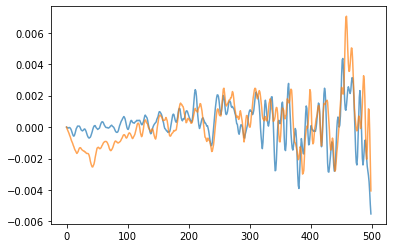

In [245]:
for chan in wave.unbind(0):
    plt.plot(chan[:500], alpha=0.7)

In [246]:
mono = wave.mean(0)

In [401]:
def preemph(x, a=1.1):
    x_ = torch.cat((torch.zeros_like(x[:1]), x), 0)
    y = a*x_[1:] - x_[:-1]
    return y
    
def deemph(ys, a=1.1):
    x_ = torch.zeros_like(ys[:1])
    xs = []
    for y in ys:
        x = (y + x_)/a
        x_ = x
        xs.append(x)
    return torch.cat(xs, 0)

In [402]:
filt = preemph(mono)
# TODO: use preemph

In [247]:
t = torch.arange(len(mono))/sr

In [312]:
n_freq = 256
f_lo, f_hi = 0.1, 8000
freq = torch.linspace(math.log(f_lo), math.log(f_hi), n_freq).exp()
phase = freq * t[:,None] * math.pi * 2
feat = torch.cat((phase.sin(), phase.cos()), 1)

In [313]:
# freq

torch.Size([304847, 512])

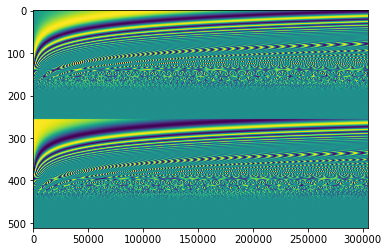

In [314]:
plt.imshow(feat.T, aspect='auto')
feat.shape

In [315]:
# TODO: time jit version
# TODO: effect of dropout?
h = 256
model = (#torch.jit.script(
    nn.Sequential(
        nn.Dropout(0.5), 
        nn.Linear(2*n_freq, h), nn.ReLU(), nn.Dropout(0.1),
        nn.Linear(h, h), nn.ReLU(), nn.Dropout(0.1),
        nn.Linear(h, h), nn.ReLU(), nn.Dropout(0.1),
        nn.Linear(h, 1, bias=False), nn.Tanh()
    )
)

In [316]:
seen_idx = torch.zeros(len(mono))

In [317]:
batch_size = 1024

In [318]:
# TODO: learning rate
opt = torch.optim.Adam(model.parameters(), 1e-4)
losses = []

100%|██████████| 100000/100000 [1:05:13<00:00, 25.55it/s]


0.008712119422852993

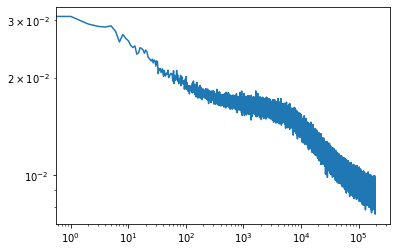

In [421]:
model.train()
for _ in tqdm(range(100000)):
    model.zero_grad()
    idx = torch.multinomial((3*(seen_idx.mean()-seen_idx)).exp(), batch_size)
    batch = feat[idx, :]
    target = mono[idx]
    seen_idx[idx] += 1
#     batch = feat[:1000]
#     target = mono[:1000]
    result = model(batch)[:,0]
    loss = (result - target).abs().mean()
#     loss = (result - target).pow(2).sum().sqrt()
    loss.backward()
    opt.step()
    losses.append(loss.item())
model.eval()
plt.plot(losses)
plt.loglog()
loss.item()

In [422]:
recon = model(feat)[:,0]
recon.shape

torch.Size([304847])

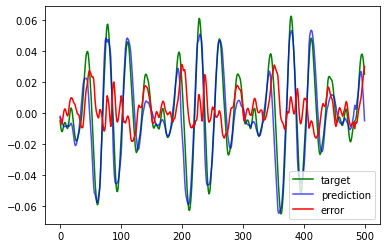

In [423]:
s,d=2000,500
# s,d=1000,200
plt.plot(mono[s:s+d], label='target', c='g')
plt.plot((recon).detach()[s:s+d], label='prediction', c='b', alpha=0.7)
plt.plot((mono-recon).detach()[s:s+d], label='error', c='r')
plt.legend()

In [424]:
spect = torchaudio.transforms.Spectrogram(4096, sr//25, sr//100)
eps = 1e-6

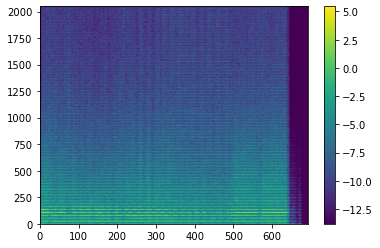

In [425]:
recon_spect = (spect(recon.detach())+eps).log()
plt.imshow(recon_spect, aspect='auto', origin='lower')
plt.colorbar()

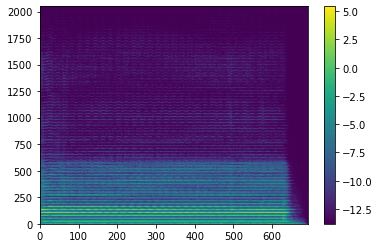

In [426]:
gt_spect = (spect(mono)+eps).log()
plt.imshow(gt_spect, aspect='auto', origin='lower')
plt.colorbar()

In [427]:
display('reconstruction', Audio(recon.detach(), rate=sr))
display('ground truth', Audio(mono, rate=sr))

'reconstruction'

'ground truth'

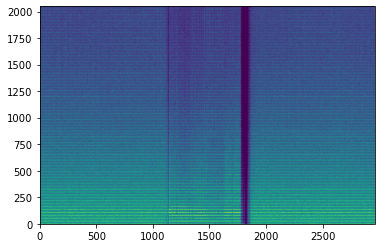

In [428]:
t_ext = torch.arange(-500000, len(mono)+500000)/sr
phase_ext = freq * t_ext[:,None] * math.pi * 2
feat_ext = torch.cat((phase_ext.sin(), phase_ext.cos()), 1)
ext = model(feat_ext)[:,0].detach()
ext_spect = (spect(ext)+eps).log()
plt.imshow(ext_spect, aspect='auto', origin='lower')

In [429]:
display('extrapolation', Audio(ext, rate=sr))

'extrapolation'